In [1]:
import numpy as np
import pandas as pd
import dataframe_image as dfi
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

<h1>Read Datasets<h1>

In [2]:
df = pd.read_excel('Datasets_Final.xlsx')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4140 entries, 0 to 4139
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4140 non-null   int64 
 1   text_emoji  4140 non-null   object
 2   Sarcasm     4140 non-null   object
dtypes: int64(1), object(2)
memory usage: 97.2+ KB


Unnamed: 0                                         text_emoji  Sarcasm
0           0  mencemooh putus asa marah sejenis menekankan s...  Positif
1           1   jagat jagat mengenal tuhan mengenal mengenal m 😨  Positif
2           2  mbah nun s b yudhoyono j k kubu negarawan poli...  Positif
3           3  mbah nun banci komunis sengkuni sembunyi akun ...  Positif
4           4  mbah nun berlagak sandiwara silakan baca foto ...  Negatif

In [3]:
# Remove unused column/feature
df = df.drop(columns='Unnamed: 0')

In [4]:
df.head()

text_emoji  Sarcasm
0  mencemooh putus asa marah sejenis menekankan s...  Positif
1   jagat jagat mengenal tuhan mengenal mengenal m 😨  Positif
2  mbah nun s b yudhoyono j k kubu negarawan poli...  Positif
3  mbah nun banci komunis sengkuni sembunyi akun ...  Positif
4  mbah nun berlagak sandiwara silakan baca foto ...  Negatif

<h1>Checking Max Length In Every Record</h1>

In [5]:
df['token'] = df['text_emoji'].apply(lambda x: x.split())

In [6]:
df['max_words'] = df['token'].apply(lambda x: len(x))

In [7]:
df['max_words'].describe()

count    4140.000000
mean       11.430193
std         6.560750
min         1.000000
25%         6.000000
50%        10.000000
75%        15.000000
max        39.000000
Name: max_words, dtype: float64

In [8]:
df = df.drop(columns=['token', 'max_words'])

In [9]:
print(f'Total Duplicated Data: {df.duplicated().sum()}')

Total Duplicated Data: 209


In [10]:
df.loc[df.duplicated(), :]

text_emoji  Sarcasm
79        contoh firaun suka menginjak harkat pribumi 😨  Negatif
80        contoh firaun suka menginjak harkat pribumi 😨  Negatif
86             opini cak nun kafir haman qorun suroto 😨  Negatif
115   andre menilai pernyataan cak nun prabowo subia...  Negatif
118   prabowo subianto penyakit basmi prabowo memuji...  Positif
...                                                 ...      ...
4134  rt pohon kuat guncangan masyaallah sehat anies...  Negatif
4135  gue suka anies baswedan pimpin pakai narasi in...  Negatif
4136  rt orang bugis mendukung anies baswedan capres...  Negatif
4137  contoh kepemimpinan patut contoh tingkat keped...  Negatif
4138      anies baswedan gubernur terbaik milik jakarta  Negatif

[209 rows x 2 columns]

In [11]:
df = df.drop_duplicates(ignore_index = True)

In [12]:
df.head()

text_emoji  Sarcasm
0  mencemooh putus asa marah sejenis menekankan s...  Positif
1   jagat jagat mengenal tuhan mengenal mengenal m 😨  Positif
2  mbah nun s b yudhoyono j k kubu negarawan poli...  Positif
3  mbah nun banci komunis sengkuni sembunyi akun ...  Positif
4  mbah nun berlagak sandiwara silakan baca foto ...  Negatif

In [13]:
print(f'Total Duplicated Data After Handling: {df.duplicated().sum()}')

Total Duplicated Data After Handling: 0


In [ ]:
# df_duplicated = pd.DataFrame(df.loc[df['text_emoji'].duplicated()])

In [ ]:
# df_duplicated.to_excel('Duplicated_Data.xlsx')

In [14]:
print(f'Total Missing Value: \n{df.isnull().sum()}')

Total Missing Value: 
text_emoji    0
Sarcasm       0
dtype: int64


<h1>Feature Extraction Using GloVe Method</h1>

In [15]:
class GloVe:
    # constructors
    def __init__(self, corpus, embedding_size, window_size=5):
        self.corpus = corpus
        self.embedding_size = embedding_size
        self.window_size = window_size
        self.word2id = {}
        self.id2word = {}
        self.word2count = {}
        self.vocab_size = 0
        self.co_matrix = None
        self.embedding = None
        self.bias = None

    def build_vocab_information(self):
        for sentence in self.corpus:
            for word in sentence.split():
                if word not in self.word2id:
                    self.word2id[word] = self.vocab_size
                    self.id2word[self.vocab_size] = word
                    self.vocab_size += 1
                self.word2count[word] = self.word2count.get(word, 0) + 1
        print(f'Vocab Size: {self.vocab_size}')

    def build_co_matrix(self):
        self.co_matrix = np.zeros((self.vocab_size, self.vocab_size))
        for sentence in self.corpus:
            sentence = sentence.split()
            for i, center_word in enumerate(sentence):
                for j in range(max(0, i - self.window_size), i):
                    context_word = sentence[j]
                    self.co_matrix[self.word2id[center_word]][self.word2id[context_word]] += 1
                    self.co_matrix[self.word2id[context_word]][self.word2id[center_word]] += 1

    def train(self, num_epochs=300, learning_rate=0.01):
        self.embedding = (np.random.rand(self.vocab_size, self.embedding_size) - 0.5) / self.embedding_size
        self.bias = np.zeros(self.vocab_size)
        count = 0
        for epoch in range(num_epochs):
            count += 1
            loss = 0
            for i in range(self.vocab_size):
                for j in range(self.vocab_size):
                    if self.co_matrix[i][j] != 0:
                        diff = (self.embedding[i] @ self.embedding[j]) + self.bias[i] + self.bias[j] - np.log(self.co_matrix[i][j])
                        
                        loss += diff ** 2
                        
                        grad_emb_i = diff * self.embedding[j]
                        grad_emb_j = diff * self.embedding[i]
                        
                        grad_bias_i = diff
                        grad_bias_j = diff

                        self.embedding[i] -= learning_rate * grad_emb_i
                        self.embedding[j] -= learning_rate * grad_emb_j
                        self.bias[i] -= learning_rate * grad_bias_i
                        self.bias[j] -= learning_rate * grad_bias_j
                        
            print(f'Difference Iterasi {count}: {diff}\n')
            print(f'Loss Iterasi {count}: {loss}\n')
            print(f'Gradient Embedding "i" Iterasi {count}: {grad_emb_i}\n')
            print(f'Gradient Embedding "j" Iterasi {count}: {grad_emb_j}\n')
            print(f'Embedding Iterasi {count}: {self.embedding}')

            print(f'Epoch {epoch + 1}/{num_epochs} - loss {round(loss, 3)}')
            
            if loss <= 0.001:
                print('Training Stopped, loss less than equal 0.001')
                break

    def get_all_embeddings(self):
        all_embeddings = {}
        for word, word_id in self.word2id.items():
            all_embeddings[word] = self.embedding[word_id]
        return all_embeddings
    
    def get_embeddings_by_id(self, id):
        return self.embedding[id]
    
    def get_embeddings(self, kata):
        word_embeddings = {}
        for word, word_id in self.word2id.items():
            if word == kata:
                word_embeddings[word] = self.embedding[word_id]
        return word_embeddings

    def embedding2word(self):
        embedding_to_word = {}
        for word, word_id in self.word2id.items():
            embedding_to_word[tuple(self.embedding[word_id])] = word
        return embedding_to_word
    
    def get_glove_embedding(self, sentence):
        sentence = sentence.split()
        embedding_vectors = []
        for word in sentence:
            if word in self.word2id:
                word_id = self.word2id[word]
                word_embedding = self.embedding[word_id]
                embedding_vectors.append(word_embedding)
        return embedding_vectors
    
    def show_comatrix(self):
        # df_co_matrix = pd.DataFrame(self.co_matrix, index=self.word2id.keys(), columns=self.word2id.keys())
        
        return self.co_matrix
    
    def generate_coomatrix_image(self):
        df_co_matrix = pd.DataFrame(self.co_matrix, index=self.word2id.keys(), columns=self.word2id.keys())

        print('Image is being processed...')
        dfi.export(df_co_matrix.head(10), "coocurrenceMatrixBab3.png", max_cols=10)
        
        return print('Coocurrence matrix has been successfully generated into an image')
    
    def show_word2id(self):
        return self.word2id
    
    def show_id2word(self):
        return self.id2word
    
    def show_word2count(self):
        return self.word2count

In [25]:
# Membangun model GloVe
embedding_size = 150

glove_model = GloVe(df['text_emoji'], embedding_size)

# Membangun vocabulary
glove_model.build_vocab_information()

# Membangun co-occurrence matrix
glove_model.build_co_matrix()

# Melatih model GloVe
glove_model.train()

Vocab Size: 6769
Difference Iterasi 1: 0.03420737052534675

Loss Iterasi 1: 47313.632457430314

Gradient Embedding "i" Iterasi 1: [-6.13837338e-05 -3.44128678e-05 -1.08514235e-04  9.91227062e-05
  1.02488833e-04  3.29198235e-05 -8.24988264e-05  8.72708589e-05
  4.05245792e-05 -9.96382817e-05  5.76318221e-05  6.72849640e-05
 -2.10001660e-05 -1.11122000e-04 -9.97018211e-05  9.98236538e-05
  5.05640845e-05  1.10834417e-04 -4.18988774e-05  8.83702572e-05
 -1.09601313e-04  1.02393634e-04  6.57099909e-05 -6.57659160e-05
 -7.61511493e-05 -5.63306468e-05  8.35719143e-05 -5.59238925e-05
 -7.04504899e-05 -2.19199439e-05 -1.19638570e-04 -7.22541855e-05
  7.58632520e-05  6.62741921e-05  7.21644489e-05 -8.86431311e-05
 -3.48778836e-06  3.65122310e-05 -1.17151553e-04 -7.58356756e-05
  6.01609495e-06 -6.30326224e-05  6.82988042e-05 -3.08753352e-05
 -5.00185553e-05  3.55862043e-05 -3.58599682e-06  2.87117166e-05
 -4.16207218e-05 -4.63253820e-05 -5.47994705e-05 -9.00408239e-05
  4.27822160e-05 -7.68466

In [26]:
# Menampilkan Dict word2id
word_2_id = glove_model.show_word2id()
word_2_id

{'kawan': 0,
 'sunda': 1,
 'bersatu': 2,
 'jemput': 3,
 'arteria': 4,
 'dahlan': 5,
 '😁': 6,
 'sidang': 7,
 'adat': 8,
 'daerah': 9,
 'menuntut': 10,
 'hukum': 11,
 'ga': 12,
 'tafsir': 13,
 'membanding': 14,
 'membandingkan': 15,
 'edy': 16,
 'menegakkan': 17,
 'divisi': 18,
 'humas': 19,
 'polri': 20,
 'bilang': 21,
 'palsu': 22,
 'mengeluarkan': 23,
 'membenarkan': 24,
 'plat': 25,
 'no': 26,
 'asli': 27,
 'urut': 28,
 'dada': 29,
 'deh': 30,
 'kuasa': 31,
 'mengerti': 32,
 'tsb': 33,
 'dengar': 34,
 'pendapat': 35,
 'gedung': 36,
 'dpr': 37,
 'memiliki': 38,
 'kekebalan': 39,
 'atur': 40,
 'konstitusi': 41,
 'n': 42,
 'uu': 43,
 'maaf': 44,
 'memaafkan': 45,
 'kubu': 46,
 'saran': 47,
 'dorong': 48,
 'masyarakat': 49,
 'jabar': 50,
 'menangkap': 51,
 'semoga': 52,
 'berpegang': 53,
 'komitmen': 54,
 'menenggelamkan': 55,
 'partai': 56,
 'demokrasi': 57,
 'indonesia': 58,
 'perjuangan': 59,
 'spt': 60,
 'sumbar': 61,
 'beruntung': 62,
 'kabar': 63,
 'e': 64,
 'hina': 65,
 'suku': 66

In [27]:
# Menampilkan Dict id2word
id_2_word = glove_model.show_id2word()
id_2_word

{0: 'kawan',
 1: 'sunda',
 2: 'bersatu',
 3: 'jemput',
 4: 'arteria',
 5: 'dahlan',
 6: '😁',
 7: 'sidang',
 8: 'adat',
 9: 'daerah',
 10: 'menuntut',
 11: 'hukum',
 12: 'ga',
 13: 'tafsir',
 14: 'membanding',
 15: 'membandingkan',
 16: 'edy',
 17: 'menegakkan',
 18: 'divisi',
 19: 'humas',
 20: 'polri',
 21: 'bilang',
 22: 'palsu',
 23: 'mengeluarkan',
 24: 'membenarkan',
 25: 'plat',
 26: 'no',
 27: 'asli',
 28: 'urut',
 29: 'dada',
 30: 'deh',
 31: 'kuasa',
 32: 'mengerti',
 33: 'tsb',
 34: 'dengar',
 35: 'pendapat',
 36: 'gedung',
 37: 'dpr',
 38: 'memiliki',
 39: 'kekebalan',
 40: 'atur',
 41: 'konstitusi',
 42: 'n',
 43: 'uu',
 44: 'maaf',
 45: 'memaafkan',
 46: 'kubu',
 47: 'saran',
 48: 'dorong',
 49: 'masyarakat',
 50: 'jabar',
 51: 'menangkap',
 52: 'semoga',
 53: 'berpegang',
 54: 'komitmen',
 55: 'menenggelamkan',
 56: 'partai',
 57: 'demokrasi',
 58: 'indonesia',
 59: 'perjuangan',
 60: 'spt',
 61: 'sumbar',
 62: 'beruntung',
 63: 'kabar',
 64: 'e',
 65: 'hina',
 66: 'suku'

In [28]:
# Menampilkan Dict word2count
word_2_count = glove_model.show_word2count()
word_2_count

{'kawan': 40,
 'sunda': 19,
 'bersatu': 14,
 'jemput': 7,
 'arteria': 35,
 'dahlan': 31,
 '😁': 492,
 'sidang': 4,
 'adat': 18,
 'daerah': 45,
 'menuntut': 6,
 'hukum': 55,
 'ga': 187,
 'tafsir': 2,
 'membanding': 1,
 'membandingkan': 12,
 'edy': 29,
 'menegakkan': 8,
 'divisi': 1,
 'humas': 1,
 'polri': 9,
 'bilang': 63,
 'palsu': 10,
 'mengeluarkan': 4,
 'membenarkan': 4,
 'plat': 4,
 'no': 16,
 'asli': 38,
 'urut': 1,
 'dada': 2,
 'deh': 32,
 'kuasa': 9,
 'mengerti': 10,
 'tsb': 19,
 'dengar': 12,
 'pendapat': 9,
 'gedung': 5,
 'dpr': 64,
 'memiliki': 53,
 'kekebalan': 1,
 'atur': 15,
 'konstitusi': 11,
 'n': 47,
 'uu': 16,
 'maaf': 67,
 'memaafkan': 5,
 'kubu': 38,
 'saran': 7,
 'dorong': 2,
 'masyarakat': 171,
 'jabar': 6,
 'menangkap': 3,
 'semoga': 207,
 'berpegang': 2,
 'komitmen': 22,
 'menenggelamkan': 3,
 'partai': 321,
 'demokrasi': 130,
 'indonesia': 475,
 'perjuangan': 123,
 'spt': 24,
 'sumbar': 1,
 'beruntung': 14,
 'kabar': 17,
 'e': 23,
 'hina': 13,
 'suku': 10,
 'peja

In [ ]:
# Menampilkan hasil dari Cooccurence Matrix
co_matrix = glove_model.show_comatrix()

co_matrix

In [ ]:
# # Generate image Matrix Coocurrence
# generateCooMatrix = glove_model.generate_coomatrix_image()

# generateCooMatrix

In [29]:
word_embeddings = glove_model.get_embeddings('😁')

print(word_embeddings)

{'😁': array([ 1.72645141e-01,  1.71961818e-01, -3.73728948e-01, -9.87215801e-02,
       -1.65630300e-01,  3.53403565e-02, -1.13989931e-01, -4.13518879e-04,
        2.03586811e-02,  2.08648730e-01, -2.28418170e-01,  2.21924810e-01,
        1.27003214e-01, -2.24139276e-01,  2.12033890e-01,  2.50670914e-01,
       -2.74668844e-01,  3.65106566e-02,  4.63040180e-01, -7.15745470e-02,
       -9.38696518e-02,  6.13933602e-02,  1.21242208e-02, -3.39973347e-01,
       -1.77595772e-01,  1.72527504e-01, -1.83191871e-01,  3.81987463e-01,
        8.89362484e-02, -7.24733172e-02, -1.83640962e-01, -1.94120072e-01,
       -9.94743823e-02,  2.23597988e-01, -9.49098061e-02, -1.98927905e-01,
       -1.79419053e-01,  1.35371998e-01, -6.73529118e-02, -8.57824847e-02,
        1.35596207e-01, -8.98471000e-04, -2.80628501e-01,  3.38253533e-02,
       -9.55979106e-02,  9.48067895e-02,  3.42090082e-02, -1.14943440e-01,
        8.82328337e-02, -1.61705073e-01, -5.45124060e-02, -3.18995974e-02,
        2.97581927e

In [30]:
embedding_by_id = glove_model.get_embeddings_by_id(6)

embedding_by_id

array([ 1.72645141e-01,  1.71961818e-01, -3.73728948e-01, -9.87215801e-02,
       -1.65630300e-01,  3.53403565e-02, -1.13989931e-01, -4.13518879e-04,
        2.03586811e-02,  2.08648730e-01, -2.28418170e-01,  2.21924810e-01,
        1.27003214e-01, -2.24139276e-01,  2.12033890e-01,  2.50670914e-01,
       -2.74668844e-01,  3.65106566e-02,  4.63040180e-01, -7.15745470e-02,
       -9.38696518e-02,  6.13933602e-02,  1.21242208e-02, -3.39973347e-01,
       -1.77595772e-01,  1.72527504e-01, -1.83191871e-01,  3.81987463e-01,
        8.89362484e-02, -7.24733172e-02, -1.83640962e-01, -1.94120072e-01,
       -9.94743823e-02,  2.23597988e-01, -9.49098061e-02, -1.98927905e-01,
       -1.79419053e-01,  1.35371998e-01, -6.73529118e-02, -8.57824847e-02,
        1.35596207e-01, -8.98471000e-04, -2.80628501e-01,  3.38253533e-02,
       -9.55979106e-02,  9.48067895e-02,  3.42090082e-02, -1.14943440e-01,
        8.82328337e-02, -1.61705073e-01, -5.45124060e-02, -3.18995974e-02,
        2.97581927e-02, -

In [31]:
all_embedding = glove_model.get_all_embeddings()

all_embedding['kawan']

array([ 0.13866269,  0.21890234,  0.09218679,  0.23154498,  0.05260381,
       -0.18254332,  0.0148109 , -0.24716445, -0.09289539, -0.05341877,
       -0.03588736, -0.11396067, -0.14686196, -0.11092585,  0.17777542,
       -0.10708508,  0.07685054,  0.08196429, -0.06430258, -0.04463621,
       -0.10190072, -0.09209554,  0.05473403,  0.03048467,  0.13933763,
        0.00675469,  0.17380573, -0.01266973,  0.06970052, -0.18607045,
       -0.16362255, -0.27978825,  0.15206938,  0.23410425, -0.15367573,
        0.18008264,  0.1425858 ,  0.14058182,  0.08179359,  0.02329865,
       -0.07711526,  0.22278682, -0.03484566,  0.31960768,  0.1649335 ,
        0.12605916,  0.14018289, -0.15323181, -0.14750196, -0.05776078,
       -0.00943602, -0.20468867,  0.11759507,  0.0376124 ,  0.20652019,
       -0.07633969, -0.17153993,  0.06926615,  0.02995884,  0.09424945,
        0.1868265 ,  0.09858819, -0.10814667,  0.10034625,  0.06492498,
        0.00934756,  0.18294062, -0.2825197 ,  0.0352203 , -0.06

In [32]:
# # Menyimpan embedding ke file teks

# embeddings = glove_model.get_all_embeddings()

# output_file = "Misc/Embeddings/embeddings150D_300E.txt"
# with open(output_file, "w", encoding="utf-8") as file:
#     for word, embedding in embeddings.items():
#         embedding_line = "{} {}\n".format(word, " ".join(str(value) for value in embedding))
#         file.write(embedding_line)

# print("Embedding telah berhasil disimpan ke: {}".format(output_file))

Embedding telah berhasil disimpan ke: Misc/Embeddings/embeddings150D_300E.txt


<h1>Create New Feature for Word Embeddings</h1>

In [ ]:
# df_ready['embedding'] = df_ready['text_emoji'].apply(lambda x: glove_model.get_glove_embedding(x))

In [ ]:
# df_ready.head()

<h2>Fungsi untuk merubah token menjadi representasi word embedding</h2>

In [ ]:
def replace_token_with_word_embedding(text):
    embeddings = []
    for word in text.split():
        if word in all_embedding:
            embeddings.append(all_embedding[word])
    
    return np.array(embeddings)

In [ ]:
kalimat = df['text_emoji'][0]
output = []

for sentence in kalimat.split():
    if sentence in all_embedding:
        output.append(all_embedding[sentence])
    
print(len(np.array(output)))

In [ ]:
df['vector'] = df['text_emoji'].apply(replace_token_with_word_embedding)

In [ ]:
df.head()

In [ ]:
# df_ready['text_emoji'].duplicated().sum()

In [ ]:
# df_ready.head()

In [ ]:
# df_ready['text_emoji'][0]

In [ ]:
# embedding2word = glove_model.embedding2word()

# embedding2word[tuple(df_ready['text_emoji'][0][0])]

<h1>Implement SMOTE</h1>

In [16]:
df['Sarcasm'] = df['Sarcasm'].replace('Positif', 1)
df['Sarcasm'] = df['Sarcasm'].replace('Negatif', 0)

In [17]:
X = np.array(df['text_emoji'])
y = np.array(df['Sarcasm'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# Cek class minoritas
print(f'Total Sample for each class:\n{y_train.value_counts()}')

<p>Terlihat Bahwa class minoritas adalah class dengan nilai 1(Positif)</p>

In [ ]:
y_train

In [ ]:
np.where(y_train == 1)[0]

In [ ]:
X_train[np.where(y_train == 1)[0]]

In [16]:
max_len = 39
len_voc = 40000

In [ ]:
df_train_min = X_train[np.where(y_train == 1)[0]]
df_train_maj = X_train[np.where(y_train == 0)[0]]

df_test = X_test

In [ ]:
df_train_min

In [ ]:
new_arrays_train_min = []

for i in df_train_min:
    new_array = np.delete(i, -1)
    new_arrays_train_min.append(new_array)

df_train_min_text = np.concatenate(new_arrays_train_min)

In [ ]:
df_train_min_text

In [ ]:
new_arrays_train_maj = []

for i in df_train_maj:
    new_array = np.delete(i, -1)
    new_arrays_train_maj.append(new_array)

df_train_maj_text = np.concatenate(new_arrays_train_maj)

In [ ]:
new_arrays_test = []

for i in df_test:
    new_array = np.delete(i, -1)
    new_arrays_test.append(new_array)

df_test_text = np.concatenate(new_arrays_test)

In [ ]:
len(df_train_min_text)

In [ ]:
len(df_train_maj_text)

In [ ]:
len(df_test_text)

In [ ]:
# df_ready_min = pd.concat([df_train_min, df_test_min])
# df_ready_maj = pd.concat([df_train_maj, df_test_maj])

In [21]:
# Tokenizing
def make_tokenizer(texts, len_voc):
    from keras.preprocessing.text import Tokenizer
    t = Tokenizer(num_words=len_voc)
    t.fit_on_texts(texts)
    
    return t

<h2>Tokenizer</h2>

In [ ]:
tokenizer = make_tokenizer(X_train, len_voc)

In [ ]:
# tokenizer_test = make_tokenizer(X_test, len_voc)

In [ ]:
tokenizer_train_min = make_tokenizer(df_train_min_text, len_voc)
tokenizer_train_maj = make_tokenizer(df_train_maj_text, len_voc)
tokenizer_test = make_tokenizer(df_test_text, len_voc)

In [22]:
word_index = tokenizer.word_index

<h2>Sequence</h2>

In [23]:
X_train_Sequence = tokenizer.texts_to_sequences(X_train)

In [24]:
X_test_Sequence = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train_min = tokenizer_train_min.texts_to_sequences(df_train_min_text)
X_train_major = tokenizer_train_maj.texts_to_sequences(df_train_maj_text)
X_test = tokenizer_test.texts_to_sequences(df_test_text)

# X_train_Sentiment = df_train['Sentimen_Text']
# X_test_Sentiment = df_test['Sentimen_Text']

In [ ]:
X_train_min

In [ ]:
X_train_major

<h2>Padding</h2>

In [25]:
from keras.utils import pad_sequences

X_train_Padded = pad_sequences(X_train_Sequence, maxlen=max_len, padding='post', truncating='post')

In [26]:
X_test_Padded = pad_sequences(X_test_Sequence, maxlen=max_len, padding='post', truncating='post')

In [ ]:
from keras.utils import pad_sequences

X_train_min = pad_sequences(X_train_min, maxlen=max_len, padding='post', truncating='post')
X_train_major = pad_sequences(X_train_major, maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

In [ ]:
X_train_min

<h2>Stacking Label Minority</h2>

In [ ]:
y_train_min = y_train[np.where(y_train == 1)[0]]

In [ ]:
y_train_min.shape

<h2>Stacking Label Majority</h2>

In [ ]:
y_train_maj = y_train[np.where(y_train == 0)[0]]

In [ ]:
y_train_maj.shape

<h2>Stacking Sentiment Minority</h2>

In [ ]:
X_train_sentiment_min = []
for i in range(len(df_train_min)):
    X_train_sentiment_min.append(df_train_min[i][1])

X_train_sentiment_min = np.array(X_train_sentiment_min)

In [ ]:
X_train_sentiment_min = X_train_sentiment_min.reshape(X_train_sentiment_min.shape[0], 1)

In [ ]:
X_train_sentiment_min

In [ ]:
X_train_sentiment_min.shape

<h2>Stacking Sentiment Majority</h2>

In [ ]:
X_train_sentiment_maj = []
for i in range(len(df_train_maj)):
    X_train_sentiment_maj.append(df_train_maj[i][1])

X_train_sentiment_maj = np.array(X_train_sentiment_maj)

In [ ]:
X_train_sentiment_maj = X_train_sentiment_maj.reshape(X_train_sentiment_maj.shape[0], 1)

In [ ]:
X_train_sentiment_maj

In [ ]:
X_train_sentiment_maj.shape

<h2>Stacking Sentiment Testing</h2>

In [ ]:
X_test_sentiment = []
for i in range(len(df_test)):
    X_test_sentiment.append(df_test[i][1])

X_test_sentiment = np.array(X_test_sentiment)

In [ ]:
X_test_sentiment = X_test_sentiment.reshape(X_test_sentiment.shape[0], 1)

In [ ]:
X_test_sentiment

In [ ]:
X_test_sentiment.shape

In [17]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def load_embedding(file):
    embeddings_index = dict(get_coefs(*i.split(" ")) for i in open(file, encoding='utf-8'))
    
    return embeddings_index

In [18]:
def make_embedding_matrix(embedding, tokenizer, len_voc):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = tokenizer.word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    # embedding_matrix = np.zeros((len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [19]:
glove_50D = load_embedding('Misc/Embeddings/embeddings50D_300E.txt')
glove_100D = load_embedding('Misc/Embeddings/embeddings100D_300E.txt')
glove_150D = load_embedding('Misc/Embeddings/embeddings150D_300E.txt')

In [ ]:
embed_matrix_50D = make_embedding_matrix(glove_50D, tokenizer, len_voc)
embed_matrix_100D = make_embedding_matrix(glove_100D, tokenizer, len_voc)
embed_matrix_150D = make_embedding_matrix(glove_150D, tokenizer, len_voc)

In [31]:
X_train_embedding = embed_matrix_100D[X_train_Padded]

In [32]:
# embed_matrix_test = make_embedding_matrix(glove, tokenizer_test, len_voc)

X_test_embedding = embed_matrix_100D[X_test_Padded]

In [33]:
train_size, max_len, embed_size = X_train_embedding.shape
X_train_embedding_r = X_train_embedding.reshape(train_size, max_len*embed_size)

test_size, max_len, embed_size = X_test_embedding.shape
X_test_embedding_r = X_test_embedding.reshape(test_size, max_len*embed_size)

In [33]:
smote = SMOTE()

X_oversampled, y_oversampled = smote.fit_resample(X_train_embedding_r, y_train)

In [34]:
unique_values, value_counts = np.unique(y_oversampled, return_counts=True)

for value, counts in zip(unique_values, value_counts):
    print(f'{value}: {counts}')

0: 1804
1: 1804


In [ ]:
embed_mat_train_min = make_embedding_matrix(glove, tokenizer_train_min, len_voc)
embed_mat_train_maj = make_embedding_matrix(glove, tokenizer_train_maj, len_voc)

embed_mat_test = make_embedding_matrix(glove, tokenizer_test, len_voc)

In [ ]:
embed_mat_train_min.shape

In [ ]:
X_train_emb_minority = embed_mat_train_min[X_train_min]
X_train_emb_majority = embed_mat_train_maj[X_train_major]

X_test_emb = embed_mat_test[X_test]

In [ ]:
X_train_emb_minority

In [ ]:
train_size_min, max_len_min, embed_size_min = X_train_emb_minority.shape
X_train_emb_r_min = X_train_emb_minority.reshape(train_size_min, max_len*embed_size_min)

train_size_maj, max_len_maj, embed_size_maj = X_train_emb_majority.shape
X_train_emb_r_maj = X_train_emb_majority.reshape(train_size_maj, max_len*embed_size_maj)

In [ ]:
X_train_emb_r_min.shape

In [ ]:
X_train_emb_r_maj.shape

In [ ]:
test_size, max_len, embed_size = X_test_emb.shape
X_test_emb_r = X_test_emb.reshape(test_size, max_len*embed_size)

In [ ]:
X_test_emb_r.shape

<h2>Stacking All Data Minority & Majority</h2>

In [ ]:
stack_train_minority = np.hstack((X_train_emb_r_min, X_train_sentiment_min))
stack_train_majority = np.hstack((X_train_emb_r_maj, X_train_sentiment_maj))

stack_testing = np.hstack((X_test_emb_r, X_test_sentiment))

In [ ]:
print(f'Shape stack minority: {stack_train_minority.shape}')
print(f'Shape stack majority: {stack_train_majority.shape}')

In [ ]:
# test_size, max_len, embed_size = X_test_emb.shape
# X_test_emb_r = X_test_emb.reshape(test_size, max_len*embed_size)

In [ ]:
# X = df_ready['embedding']
# X_sentiment = np.array(df_ready['Sentimen_Text']).reshape(-1, 1)
# y = np.array(df_ready['Sarcasm'])

In [ ]:
# from sklearn.model_selection import train_test_split
# # Bagi dataset menjadi train set dan test set
# X_train, X_test, X_sentiment_train, X_sentiment_test, y_train, y_test = train_test_split(X, X_sentiment, y, test_size=0.4, random_state=42)

In [ ]:
# X_minority = X_train[y_train == 1]
# X_sentiment_minority = X_sentiment_train[y_train == 1]
# y_minority = y_train[y_train == 1]

In [ ]:
# len(X_minority)

In [83]:
from sklearn.neighbors import NearestNeighbors

def get_neighbors(data_minority, k):
    euclidian = NearestNeighbors(n_neighbors=k+1,metric='euclidean',algorithm='kd_tree').fit(data_minority)
    euclidians, indices = euclidian.kneighbors((data_minority))
    nn = []
    for i in range(len(data_minority)):
        value = indices[i][indices[i] != i]
        nn.append(value)
    nn = np.array(nn)
    print(f'Euclidians :\n{euclidians}\n')
    
    return nn

def generate_synthetic_samples(X_minority, neighbors):
    synthetic_samples = []

    for i in range(len(X_minority)):
        minority_neighbors = neighbors[i]
        nn = np.random.choice(minority_neighbors, size=1, replace=False)
        alpha = np.random.uniform(0, 1)
        synthetic_sample = X_minority[i] + alpha * (X_minority[nn] - X_minority[i])
        
        if synthetic_sample.size > 1:
            synthetic_sample = synthetic_sample[:1]

        print(synthetic_sample)
        
        synthetic_samples.append(synthetic_sample)

    data_synthetic = np.vstack(synthetic_samples)
    for i in range(len(synthetic_samples)):
        print(synthetic_samples[i].shape)
    return data_synthetic

def smote(X_minority, y_minority, label_minority, k): 
    # Mendapatkan tetangga terdekat untuk setiap sampel minoritas
    neighbors = get_neighbors(X_minority, k)
    print('Neighbors\n')
    print(f'{neighbors}\n')
    print(f'Length : {neighbors.shape[0]}\n')
    
    # Menghasilkan sampel sintetis
    print('Synthetic Data\n')
    synthetic_samples = generate_synthetic_samples(X_minority, neighbors)
    
    if label_minority == 0:
        synthetic_labels = np.zeros(len(synthetic_samples))
    else:
        synthetic_labels = np.ones(len(synthetic_samples))
    
    # Menggabungkan sampel minoritas asli dengan sampel sintetis
    X_oversampled = np.vstack((X_minority, synthetic_samples))
    y_oversampled = np.hstack((y_minority, synthetic_labels))
    
    return X_oversampled, y_oversampled

In [ ]:
total_size = train_size_maj + train_size_min + test_size

In [ ]:
# Menjalankan SMOTE pada data stack
X_minority = stack_train_minority
y_minority = y_train_min
X_majority = stack_train_minority
y_majority = y_train_maj

X_oversampled, y_oversampled = smote(X_minority, X_majority, y_minority, k=5)

# Memisahkan kembali data menjadi train dan test set
X_train_oversampled = X_oversampled[:total_size]
X_test_oversampled = X_oversampled[total_size:]

y_train_oversampled = y_oversampled[:total_size]
y_test_oversampled = y_oversampled[total_size:]

In [ ]:
final_stack = np.vstack((stack_train_majority, X_oversampled))

In [ ]:
len(final_stack)

In [ ]:
final_stack = np.delete(final_stack, np.s_[4024::], axis=0)

In [ ]:
final_stack.shape

In [ ]:
final_stack_label = np.hstack((y_train_maj, y_oversampled))

In [ ]:
final_stack_label = np.delete(final_stack_label, np.s_[4024::], axis=0)

In [ ]:
print(f'Final Shape Data: {final_stack.shape}\n')

In [ ]:
print(f'Final Shape Label: {final_stack_label.shape}\n')

In [ ]:
# Menghitung Jumlah Akhir Sample pada Class 0 dan 1
unique, counts = np.unique(final_stack_label, return_counts=True)
result = np.asarray((unique, counts)).T.astype(int)

print(result[0][1])

In [ ]:
import matplotlib.pyplot as plt

x = ['Sebelum', 'Sesudah']
y = [len(X_train_emb_r_min) + len(X_train_emb_r_maj), len(final_stack)]


plt.bar(x, y, color=[(0.38, 0.62, 0.79), (0.98, 0.64, 0.33)], edgecolor='black', linewidth=1.5)

for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='bottom')

plt.ylabel('Jumlah Sample')
plt.title('Perbandingan Data Training Setelah Diimplementasi SMOTE')

plt.show()

In [ ]:
x = ['0', '1']
y = [1794, 1718]


plt.bar(x, y, color=[(0.38, 0.62, 0.79), (0.98, 0.64, 0.33)], edgecolor='black', linewidth=1.5)

for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='bottom')

plt.ylabel('Jumlah Sample')
plt.title('Jumlah Sample Masing-Masing Kelas Pada Data Training Sebelum Di Implementasi SMOTE')

plt.show()

In [ ]:
x = ['0', '1']
y = [result[0][1], result[1][1]]


plt.bar(x, y, color=[(0.38, 0.62, 0.79), (0.98, 0.64, 0.33)], edgecolor='black', linewidth=1.5)

for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='bottom')

plt.ylabel('Jumlah Sample')
plt.title('Jumlah Sample Masing-Masing Kelas Setelah Di Implementasi SMOTE')

plt.show()

In [ ]:
# X_embedding = np.array(df_ready['embedding'][:2]).reshape(-1, 1)
# sentiment_values = np.array(df_ready['Sentimen_Text'][:2]).reshape(-1, 1)

# num_rows = X_embedding.shape[0]

# X_sentiment = np.empty((num_rows, 1), dtype=np.str_)

# for i in range(num_rows):
#     X_sentiment[i] = sentiment_values[i % sentiment_values.shape[0]]

# X = np.hstack((X_embedding, X_sentiment))

# X

In [ ]:
# y = df_ready['Sarcasm']

# y

In [ ]:
# from sklearn.neighbors import NearestNeighbors

# def get_k_nearest_neighbors(X, sample, k):
#     # Mencari tetangga terdekat menggunakan k-NN
#     knn = NearestNeighbors(n_neighbors=k+1)
#     knn.fit(X)
    
#     # Mengembalikan indeks tetangga terdekat untuk sampel
#     _, indices = knn.kneighbors([sample])
#     indices_1d = indices.flatten()  # Mengubah menjadi 1D array
    
#     return indices_1d[1:]  # Menghilangkan indeks diri sendiri

In [ ]:
# import pandas as pd
# import numpy as np
# import math

# def SMOTE(df, k, oversampling_ratio):
#     # Mendapatkan array numpy dari fitur embedding, sentiment, dan label
#     embeddings = np.vstack(df['embedding'].to_numpy())
#     labels = df['Sarcasm'].to_numpy()
    
#     # Menginisialisasi array untuk menyimpan sampel sintetis yang dihasilkan
#     synthetic_samples = []
    
#     # Mencari indeks sampel minoritas dan mayoritas
#     minority_indices = np.where(labels == 1)[0]
#     majority_indices = np.where(labels == 0)[0]
    
#     # Menghitung jumlah sampel sintetis yang akan dibuat untuk kelas minoritas
#     num_minority_samples = len(minority_indices)
#     num_majority_samples = len(majority_indices)
    
#     num_synthetic_samples = min(num_majority_samples - num_minority_samples, math.ceil(num_minority_samples * oversampling_ratio))
    
#     if num_synthetic_samples <= 0:
#         return pd.DataFrame()  # Return empty DataFrame jika tidak ada sampel sintetis yang perlu dibuat
    
#     # Looping melalui setiap sampel minoritas
#     for i in minority_indices:
#         sample = embeddings[i]
        
#         # Mencari tetangga terdekat untuk sampel minoritas
#         neighbors = get_k_nearest_neighbors(embeddings, sample, k)
        
#         # Menghasilkan sampel sintetis
#         for j in range(num_synthetic_samples):
#             # Memilih satu tetangga acak
#             neighbor_index = np.random.choice(neighbors)
            
#             if neighbor_index >= len(embeddings):
#                 continue  # Skip jika indeks tetangga melebihi ukuran data yang valid
            
#             neighbor = embeddings[neighbor_index]
            
#             # Menghitung selisih antara sampel dan tetangga
#             diff = neighbor - sample
            
#             # Menghasilkan sampel sintetis dengan proporsi acak
#             proportion = np.random.uniform(0, 1, size=1)
#             synthetic_sample = sample + proportion * diff
            
#             # Menambahkan sampel sintetis ke array
#             synthetic_samples.append(synthetic_sample)
    
#     # Mengubah array numpy ke DataFrame
#     embedding_array = np.vstack(synthetic_samples)
#     embedding_df = pd.DataFrame(embedding_array, columns=['embedding'] * embedding_array.shape[1])
#     sarcasm_df = pd.DataFrame(np.zeros((embedding_array.shape[0], 1)), columns=['Sarcasm'])
#     synthetic_df = pd.concat([embedding_df, sarcasm_df], axis=1)
    
#     # Menambahkan label kelas minoritas pada data sintetis
#     synthetic_df['Sarcasm'] = 1

#     return synthetic_df

In [ ]:
# oversampled_df = SMOTE(df_ready, k=5, oversampling_ratio=1.0)

<h1>Training Bi-LSTM<h1>

In [44]:
# Bi-LSTM Algorithm

import numpy as np
import pickle as pkl

# activation function sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Turunan activation function sigmoid
def sigmoid_derivative(x):
    return x * (1 - x)

# activation function tanh
def tanh(x):
    return np.tanh(x)

# Turunan activation function tanh
def tanh_derivative(x):
    return 1 - x**2

class BiLSTM:
    # Constructor
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Parameter untuk Input Gate Menggunakan Metode Xavier
        self.W_i = np.random.uniform(-1, 1, (hidden_size, input_size)) * np.sqrt(1 / input_size)
        self.U_i = np.random.uniform(-1, 1, (hidden_size, hidden_size)) * np.sqrt(1 / hidden_size)
        self.b_i = np.zeros((hidden_size, 1))
        
        # Parameter untuk Forget Gate Menggunakan Metode Xavier
        self.W_f = np.random.uniform(-1, 1, (hidden_size, input_size)) * np.sqrt(1 / input_size)
        self.U_f = np.random.uniform(-1, 1, (hidden_size, hidden_size)) * np.sqrt(1 / hidden_size)
        self.b_f = np.zeros((hidden_size, 1))
        
        # Parameter untuk Output Gate Menggunakan Metode Xavier
        self.W_o = np.random.uniform(-1, 1, (hidden_size, input_size)) * np.sqrt(1 / input_size)
        self.U_o = np.random.uniform(-1, 1, (hidden_size, hidden_size)) * np.sqrt(1 / hidden_size)
        self.b_o = np.zeros((hidden_size, 1))
        
        # Parameter untuk Cell State Menggunakan Metode Xavier
        self.W_c = np.random.uniform(-1, 1, (hidden_size, input_size)) * np.sqrt(1 / input_size)
        self.U_c = np.random.uniform(-1, 1, (hidden_size, hidden_size)) * np.sqrt(1 / hidden_size)
        self.b_c = np.zeros((hidden_size, 1))
        
        # Parameter untuk output layer Menggunakan Metode Xavier
        self.W_y = np.random.uniform(-1, 1, (output_size, hidden_size*2)) * np.sqrt(1 / (hidden_size*2))
        self.b_y = np.zeros((output_size, 1))

        # Parameter m dan v pada Adam Optimizer untuk setiap parameter
        self.mW_i, self.vW_i = np.zeros_like(self.W_i), np.zeros_like(self.W_i)
        self.mU_i, self.vU_i = np.zeros_like(self.U_i), np.zeros_like(self.U_i)
        self.mb_i, self.vb_i = np.zeros_like(self.b_i), np.zeros_like(self.b_i)
        
        self.mW_f, self.vW_f = np.zeros_like(self.W_f), np.zeros_like(self.W_f)
        self.mU_f, self.vU_f = np.zeros_like(self.U_f), np.zeros_like(self.U_f)
        self.mb_f, self.vb_f = np.zeros_like(self.b_f), np.zeros_like(self.b_f)

        self.mW_o, self.vW_o = np.zeros_like(self.W_o), np.zeros_like(self.W_o)
        self.mU_o, self.vU_o = np.zeros_like(self.U_o), np.zeros_like(self.U_o)
        self.mb_o, self.vb_o = np.zeros_like(self.b_o), np.zeros_like(self.b_o)

        self.mW_c, self.vW_c = np.zeros_like(self.W_c), np.zeros_like(self.W_c)
        self.mU_c, self.vU_c = np.zeros_like(self.U_c), np.zeros_like(self.U_c)
        self.mb_c, self.vb_c = np.zeros_like(self.b_c), np.zeros_like(self.b_c)

        self.mW_y, self.vW_y = np.zeros_like(self.W_y), np.zeros_like(self.W_y)
        self.mb_y, self.vb_y = np.zeros_like(self.b_y), np.zeros_like(self.b_y)

        self.count = 0
        
    def forward_backward(self, x):
        T = len(x)
        # print(T)
        self.count += 1

        self.h_forward = np.zeros((T + 1, self.hidden_size))
        self.c_forward = np.zeros((T + 1, self.hidden_size))
        self.h_backward = np.zeros((T + 1, self.hidden_size))
        self.c_backward = np.zeros((T + 1, self.hidden_size))
        self.gates_forward = np.zeros((T, self.hidden_size*4, self.hidden_size))
        self.gates_backward = np.zeros((T, self.hidden_size*4, self.hidden_size))
        self.outputs = np.zeros((T, self.output_size))
        
        for t in range(T):
            # Forward
            self.gates_forward[t] = np.concatenate([
                sigmoid(self.W_i @ x[t] + self.U_i @ self.h_forward[t] + self.b_i),
                sigmoid(self.W_f @ x[t] + self.U_f @ self.h_forward[t] + self.b_f),
                sigmoid(self.W_o @ x[t] + self.U_o @ self.h_forward[t] + self.b_o),
                tanh(self.W_c @ x[t] + self.U_c @ self.h_forward[t] + self.b_c)
            ])
        
            # print(f'Forget Gate Forward Iterasi {self.count}: {sigmoid(self.W_f @ x[t] + self.U_f @ self.h_forward[t] + self.b_f)}\n')
            # print(f'Input Gate Forward Iterasi {self.count}: {sigmoid(self.W_i @ x[t] + self.U_i @ self.h_forward[t] + self.b_i)}\n')
            # print(f'Output Gate Forward Iterasi {self.count}: {sigmoid(self.W_o @ x[t] + self.U_o @ self.h_forward[t] + self.b_o)}\n')
            self.c_forward[t + 1] = self.gates_forward[t, 1] * self.c_forward[t] + self.gates_forward[t, 0] * self.gates_forward[t, 3]
            self.h_forward[t + 1] = self.gates_forward[t, 2] * tanh(self.c_forward[t + 1])

            # print(f'Cell State Forward Iterasi {self.count}: {self.gates_forward[t, 1] * self.c_forward[t] + self.gates_forward[t, 0] * self.gates_forward[t, 3]}\n')
            # print(f'Hidden State Forward Iterasi {self.count}: {self.gates_forward[t, 2] * tanh(self.c_forward[t + 1])}\n')

            # backward
            t_backward = T - t - 1
            self.gates_backward[t_backward] = np.concatenate([
                sigmoid(self.W_i @ x[t_backward] + self.U_i @ self.h_backward[t_backward] + self.b_i),
                sigmoid(self.W_f @ x[t_backward] + self.U_f @ self.h_backward[t_backward] + self.b_f),
                sigmoid(self.W_o @ x[t_backward] + self.U_o @ self.h_backward[t_backward] + self.b_o),
                tanh(self.W_c @ x[t_backward] + self.U_c @ self.h_backward[t_backward] + self.b_c)
            ])
            
            # print(f'Forget Gate Backward Iterasi {self.count}: {sigmoid(self.W_f @ x[t_backward] + self.U_f @ self.h_backward[t_backward] + self.b_f)}\n')
            # print(f'Input Gate Backward Iterasi {self.count}: {sigmoid(self.W_i @ x[t_backward] + self.U_i @ self.h_backward[t_backward] + self.b_i)}\n')
            # print(f'Output Gate Backward Iterasi {self.count}: {sigmoid(self.W_o @ x[t_backward] + self.U_o @ self.h_backward[t_backward] + self.b_o)}\n')
            self.c_backward[t_backward + 1] = self.gates_backward[t_backward, 1] * self.c_backward[t_backward] + self.gates_backward[t_backward, 0] * self.gates_backward[t_backward, 3]
            self.h_backward[t_backward + 1] = self.gates_backward[t_backward, 2] * tanh(self.c_backward[t_backward + 1])

            # print(f'Cell State Backward Iterasi {self.count}: {self.gates_backward[t_backward, 1] * self.c_backward[t_backward] + self.gates_backward[t_backward, 0] * self.gates_backward[t_backward, 3]}\n')
            # print(f'Hidden State Backward Iterasi {self.count}: {self.gates_backward[t_backward, 2] * tanh(self.c_backward[t_backward + 1])}\n')

            # Merged Forward and Backward LSTM
            merged_output = np.concatenate([self.h_forward[t + 1], self.h_backward[t_backward + 1]])
            # h_reshaped = np.reshape(merged_output, (self.hidden_size*2,))
            # print(f'Final Output Reshape: {h_reshaped}\n')
            sigmoids = sigmoid(self.W_y @ merged_output + self.b_y)
            # print(f'Sigmoids: {sigmoids.shape}\n')
            self.outputs[t] = sigmoids[0]
        # print(f'Merged Output: {merged_output}\n')
        # print(f'final Outputs{self.outputs}\n')
        
        return self.outputs
    
    def backPropagation(self, x, y, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        T = len(x)
        dW_i, dU_i, db_i = np.zeros_like(self.W_i), np.zeros_like(self.U_i), np.zeros_like(self.b_i)
        dW_f, dU_f, db_f = np.zeros_like(self.W_f), np.zeros_like(self.U_f), np.zeros_like(self.b_f)
        dW_o, dU_o, db_o = np.zeros_like(self.W_o), np.zeros_like(self.U_o), np.zeros_like(self.b_o)
        dW_c, dU_c, db_c = np.zeros_like(self.W_c), np.zeros_like(self.U_c), np.zeros_like(self.b_c)
        dW_y, db_y = np.zeros_like(self.W_y), np.zeros_like(self.b_y)
        dc_next = np.zeros((1, self.hidden_size))
        dh_next = np.zeros((1, self.hidden_size))
        
        for t in reversed(range(T)):
            dy = self.outputs[t]
            # print(f'Outputs: {dy}\n')
            # print(f'{y[t]}\n')
            dy[y[t]] -= 1
            # print(f'Outputs minus 1{dy}\n')
            dy_transpose = dy.reshape(1, -1).T
            # print(f'Shape dy_transpose: {dy_transpose.shape}\n')
            # print(f'Shape self.W_y.T : {self.W_y.shape}\n')
            dh_forward = self.W_y.T @ dy_transpose + dh_next
            # print(f'Shape dh_forward: {dh_forward.shape}\n')
            dc_forward = dh_forward * self.gates_forward[t, 2] * tanh_derivative(tanh(self.c_forward[t + 1])) + dc_next
            dh_backward = self.W_y.T @ dy_transpose + dh_next
            dc_backward = dh_backward * self.gates_backward[t, 2] * tanh_derivative(tanh(self.c_backward[t + 1])) + dc_next
            
            # print(f'Shape dy_transpose: {dy_transpose.shape}\n')
            # print(f'Shape dW_y: {dW_y.shape}\n')
            # print(f'Shape self.h_forward: {self.h_forward[t + 1].shape}\n')
            # dW_y += dy_transpose @ np.expand_dims(self.h_forward[t + 1], axis=0) + dy_transpose @ np.expand_dims(self.h_backward[t + 1], axis=0) # Salah
            dW_y += dy_transpose @ np.expand_dims(np.concatenate([self.h_forward[t + 1], self.h_backward[t + 1][:self.hidden_size]]), axis=0) # Benar
            db_y += dy_transpose
            
            # print(f'dc_forward: {dc_forward.shape}, self.gates_forward[t, 3]: {self.gates_forward[t, 3].shape}\n')
            dg_forward = dc_forward * self.gates_forward[t, 2] * tanh_derivative(self.gates_forward[t, 3])
            dg_backward = dc_backward * self.gates_backward[t, 3]

            dgates_forward = self.gates_forward[t]
            # print(f'Shape dgates_forward[3]: {dgates_forward.shape}\n')
            # dg_forward_expanded = np.expand_dims(dg_forward, axis=0)
            dgated = dg_forward * tanh_derivative(dgates_forward[3])
            # print(f'tanh_derivative Shape: {dgated.shape}\n')
            # print(f'Shape dg_forward : {dg_forward.shape}')
            dgates_forward[3][:self.hidden_size] = np.sum(dg_forward[:self.hidden_size] * tanh_derivative(dgates_forward[3])[:self.hidden_size], axis=1) # Error disini
            dgates_forward[0][:self.hidden_size] = np.sum(dc_forward[:self.hidden_size] * self.gates_forward[t, 0], axis=1)
            dgates_forward[1][:self.hidden_size] = np.sum(dc_forward[:self.hidden_size] * self.c_forward[t], axis=1)
            dgates_forward[2][:self.hidden_size] = np.sum(dh_forward[:self.hidden_size] * tanh(self.c_forward[t + 1]) * sigmoid_derivative(dgates_forward[2]), axis=1)

            dgates_backward = self.gates_backward[t]
            dgates_backward[3][:self.hidden_size] = np.sum(dg_backward[:self.hidden_size] * tanh_derivative(dgates_backward[3]))
            dgates_backward[0][:self.hidden_size] = np.sum(dc_backward[:self.hidden_size] * self.gates_backward[t, 0])
            dgates_backward[1][:self.hidden_size] = np.sum(dc_backward[:self.hidden_size] * self.c_backward[t])
            dgates_backward[2][:self.hidden_size] = np.sum(dh_backward[:self.hidden_size] * tanh(self.c_backward[t + 1]) * sigmoid_derivative(dgates_backward[2]))
            
            x_transpose = np.array([x[t]])
            dgates_transpose_forward_0 = np.array([dgates_forward[0]])
            dgates_transpose_forward_1 = np.array([dgates_forward[1]])
            dgates_transpose_forward_2 = np.array([dgates_forward[2]])
            dgates_transpose_forward_3 = np.array([dgates_forward[3]])

            dgates_transpose_backward_0 = np.array([dgates_backward[0]])
            dgates_transpose_backward_1 = np.array([dgates_backward[1]])
            dgates_transpose_backward_2 = np.array([dgates_backward[2]])
            dgates_transpose_backward_3 = np.array([dgates_backward[3]])
            
            dW_i += dgates_transpose_forward_0.T @ x_transpose + dgates_transpose_backward_0.T @ x_transpose
            dU_i += dgates_forward[0] @ self.h_forward[t].T + dgates_backward[0] @ self.h_backward[t].T
            db_i += dgates_transpose_forward_0.T + dgates_transpose_backward_0.T
            
            dW_f += dgates_transpose_forward_1.T @ x_transpose + dgates_transpose_backward_1.T @ x_transpose # Error disini
            dU_f += dgates_forward[1] @ self.h_forward[t].T + dgates_backward[1] @ self.h_backward[t].T
            db_f += dgates_transpose_forward_1.T + dgates_transpose_backward_1.T
            
            dW_o += dgates_transpose_forward_2.T @ x_transpose + dgates_transpose_backward_2.T @ x_transpose
            dU_o += dgates_forward[2] @ self.h_forward[t].T + dgates_backward[2] @ self.h_backward[t].T
            db_o += dgates_transpose_forward_2.T + dgates_transpose_backward_2.T
            
            dW_c += dgates_transpose_forward_3.T @ x_transpose + dgates_transpose_backward_3.T @ x_transpose
            dU_c += dgates_forward[3] @ self.h_forward[t].T + dgates_backward[3] @ self.h_backward[t].T
            db_c += dgates_transpose_forward_3.T + dgates_transpose_backward_3.T
            
            dh_next = self.U_i.T @ dgates_forward[0] + self.U_f.T @ dgates_forward[1] + self.U_o.T @ dgates_forward[2] + self.U_c.T @ dgates_forward[3]
            dc_next = dc_forward * self.gates_forward[t, 1]
        
        # Adam Optimizer
        for param, dparam, m, v in zip([self.W_i, self.U_i, self.b_i, self.W_f, self.U_f, self.b_f, self.W_o, self.U_o, self.b_o, self.W_c, self.U_c, self.b_c, self.W_y, self.b_y],
                               [dW_i, dU_i, db_i, dW_f, dU_f, db_f, dW_o, dU_o, db_o, dW_c, dU_c, db_c, dW_y, db_y],
                               [self.mW_i, self.mU_i, self.mb_i, self.mW_f, self.mU_f, self.mb_f, self.mW_o, self.mU_o, self.mb_o, self.mW_c, self.mU_c, self.mb_c, self.mW_y, self.mb_y],
                               [self.vW_i, self.vU_i, self.vb_i, self.vW_f, self.vU_f, self.vb_f, self.vW_o, self.vU_o, self.vb_o, self.vW_c, self.vU_c, self.vb_c, self.vW_y, self.vb_y]):
            # print(f'Nilai Gradien Awal:\n{dparam}\n')
            m = beta1 * m + (1 - beta1) * dparam
            # print(f'Memperbaharui Estimasi momen pertama yang bias:\n {m}\n')
            v = beta2 * v + (1 - beta2) * (dparam ** 2)
            # print(f'Memperbaharui perkiraan momen kedua yang bias:\n {v}\n')
            m_hat = m / (1 - beta1)
            # print(f'Hasil perhitungan estimasi momen pertama yang dikoreksi bias:\n {m_hat}\n')
            v_hat = v / (1 - beta2)
            # print(f'Hasil perhitungan estimasi momen mentah kedua yang dikoreksi bias:\n {v_hat}\n')
            param -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
            # print(f'Nilai Update Parameter yang akan digunakan untuk epochs berikutnya: \n{param}')
        
        # for param in [dW_i, dU_i, db_i, dW_f, dU_f, db_f, dW_o, dU_o, db_o, dW_c, dU_c, db_c, dW_y, db_y]:
        #     np.clip(param, -1, 1, out=param)
        
        # self.W_i -= learning_rate * dW_i
        # self.U_i -= learning_rate * dU_i
        # self.b_i -= learning_rate * db_i
        
        # self.W_f -= learning_rate * dW_f
        # self.U_f -= learning_rate * dU_f
        # self.b_f -= learning_rate * db_f
        
        # self.W_o -= learning_rate * dW_o
        # self.U_o -= learning_rate * dU_o
        # self.b_o -= learning_rate * db_o
        
        # self.W_c -= learning_rate * dW_c
        # self.U_c -= learning_rate * dU_c
        # self.b_c -= learning_rate * db_c
        
        # self.W_y -= learning_rate * dW_y
        # self.b_y -= learning_rate * db_y
    
    def train(self, x, y, epochs, learning_rate):
        for epoch in range(epochs):
            outputs = self.forward_backward(x)
            self.backPropagation(x, y, learning_rate)
            # print(f'Hasil Prediksi {outputs}')
            outputs = np.clip(outputs, 1e-15, None)
            loss = -np.mean(np.log(outputs[np.arange(len(y)), y]))
            
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}')
    
    def predict(self, x):
        T = len(x)
        h_forward = np.zeros((T + 1, self.hidden_size))
        c_forward = np.zeros((T + 1, self.hidden_size))
        h_backward = np.zeros((T + 1, self.hidden_size))
        c_backward = np.zeros((T + 1, self.hidden_size))
        outputs = np.zeros((T, self.output_size))
        
        for t in range(T):
            # Forward
            gates_forward = np.concatenate([
                sigmoid(self.W_i @ x[t] + self.U_i @ h_forward[t] + self.b_i),
                sigmoid(self.W_f @ x[t] + self.U_f @ h_forward[t] + self.b_f),
                sigmoid(self.W_o @ x[t] + self.U_o @ h_forward[t] + self.b_o),
                tanh(self.W_c @ x[t] + self.U_c @ h_forward[t] + self.b_c)
            ])
                
            c_forward[t + 1] = gates_forward[1] * c_forward[t] + gates_forward[0] * gates_forward[3]
            h_forward[t + 1] = gates_forward[2] * tanh(c_forward[t + 1])
                
            # Backward
            t_backward = T - t - 1
            gates_backward = np.concatenate([
                sigmoid(self.W_i @ x[t_backward] + self.U_i @ h_backward[t_backward] + self.b_i),
                sigmoid(self.W_f @ x[t_backward] + self.U_f @ h_backward[t_backward] + self.b_f),
                sigmoid(self.W_o @ x[t_backward] + self.U_o @ h_backward[t_backward] + self.b_o),
                tanh(self.W_c @ x[t_backward] + self.U_c @ h_backward[t_backward] + self.b_c)
            ])
                
            c_backward[t_backward + 1] = gates_backward[1] * c_backward[t_backward] + gates_backward[0] * gates_backward[3]
            h_backward[t_backward + 1] = gates_backward[2] * tanh(c_backward[t_backward + 1])

            merged_output = np.concatenate([h_forward[t + 1], h_backward[t_backward + 1]])
            sigmoids = sigmoid(self.W_y @ merged_output + self.b_y)
            outputs[t] = sigmoids[0]
        
        return np.argmax(outputs, axis=1)
    
    def save_model(self, model, filename):
        with open(filename, 'wb') as f:
            pkl.dump(model, f)

<h2>Training & Testing Model</h2>

<h3>Train Model Bi-LSTM (Parameter embedding_size = 50)</h3>

<p>Bi-LSTM</p>

In [45]:
x_train = X_train_embedding_r
x_train = np.array(x_train)
# label = final_stack_label.astype('int')
y_trains = y_train

# Inisialisasi model Bi-LSTM
input_size = x_train.shape[1]
hidden_size = 6
output_size = 2
model_bilstm_embedsize_50 = BiLSTM(input_size, hidden_size, output_size)

In [36]:
x_train.shape

(3537, 3900)

In [37]:
y_trains.shape

(3537,)

In [38]:
X_test_embedding_r.shape

(394, 3900)

In [46]:
# Train ML Model
epochs = 300
learning_rate = 0.001
model_bilstm_embedsize_50.train(x_train, y_trains, epochs, learning_rate)

Epoch 1/300, Loss: 34.5388
Epoch 2/300, Loss: 34.5388
Epoch 3/300, Loss: 34.5388
Epoch 4/300, Loss: 34.5388
Epoch 5/300, Loss: 34.5388
Epoch 6/300, Loss: 34.5388
Epoch 7/300, Loss: 34.5388
Epoch 8/300, Loss: 34.5388
Epoch 9/300, Loss: 34.5388
Epoch 10/300, Loss: 34.5388
Epoch 11/300, Loss: 34.5388
Epoch 12/300, Loss: 34.5388
Epoch 13/300, Loss: 34.5388
Epoch 14/300, Loss: 34.5388
Epoch 15/300, Loss: 34.5388
Epoch 16/300, Loss: 34.5388
Epoch 17/300, Loss: 34.5388
Epoch 18/300, Loss: 34.5388
Epoch 19/300, Loss: 34.5388
Epoch 20/300, Loss: 34.5388
Epoch 21/300, Loss: 34.5388
Epoch 22/300, Loss: 34.5388
Epoch 23/300, Loss: 34.5388
Epoch 24/300, Loss: 34.5388
Epoch 25/300, Loss: 34.5388
Epoch 26/300, Loss: 34.5388
Epoch 27/300, Loss: 34.5388
Epoch 28/300, Loss: 34.5388
Epoch 29/300, Loss: 34.5388
Epoch 30/300, Loss: 34.5388
Epoch 31/300, Loss: 34.5388
Epoch 32/300, Loss: 34.5388
Epoch 33/300, Loss: 34.5388
Epoch 34/300, Loss: 34.5388
Epoch 35/300, Loss: 34.5388
Epoch 36/300, Loss: 34.5388
E

In [47]:
# Predict
output_predict = []
for i in range(len(X_test_embedding_r)):
    output_predict.append(model_bilstm_embedsize_50.predict(np.array([X_test_embedding_r[i]])))

In [48]:
output_predict

[array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], 

<h2>Pengujian Performansi</h2>

<h3>Bi-LSTM Without SMOTE</h3>

In [49]:
df_result_WS = pd.DataFrame.from_records(output_predict, columns=['Predict'])

In [50]:
df_result_WS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Predict  394 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


In [51]:
output_actual_WS = []

for i in y_test:
    output_actual_WS.append(i)

In [52]:
df_actual_WS = pd.DataFrame(output_actual_WS, columns=['Actual'])

In [53]:
df_final_result_WS = df_result_WS.join(df_actual_WS)

In [54]:
df_final_result_WS.head()

Predict  Actual
0        0       0
1        0       1
2        0       0
3        0       1
4        0       1

In [55]:
for i in range(len(df_final_result_WS)):
  if (df_final_result_WS.iloc[i]['Predict'] == 1 and df_final_result_WS.iloc[i]['Actual'] == 1):
    df_final_result_WS.loc[i, 'Category'] = 'TP'
  elif (df_final_result_WS.iloc[i]['Predict'] == 0 and df_final_result_WS.iloc[i]['Actual'] == 0):
    df_final_result_WS.loc[i, 'Category'] = 'TN'
  elif (df_final_result_WS.iloc[i]['Predict'] == 1 and df_final_result_WS.iloc[i]['Actual'] == 0):
    df_final_result_WS.loc[i, 'Category'] = 'FP'
  elif (df_final_result_WS.iloc[i]['Predict'] == 0 and df_final_result_WS.iloc[i]['Actual'] == 1):
    df_final_result_WS.loc[i, 'Category'] = 'FN'

In [59]:
TP_WS = len(df_final_result_WS[df_final_result_WS['Category']=='TP'])
TN_WS = len(df_final_result_WS[df_final_result_WS['Category']=='TN'])
FP_WS = len(df_final_result_WS[df_final_result_WS['Category']=='FP'])
FN_WS = len(df_final_result_WS[df_final_result_WS['Category']=='FN'])

accuracy_WS = round((TP_WS + TN_WS) / (TP_WS + TN_WS + FP_WS + FN_WS), 2) * 100
precision_WS = 0 if TP_WS == 0 or FP_WS == 0 else round(TP_WS / (TP_WS + FP_WS), 2) * 100
recall_WS = round(TP_WS / (TP_WS + FN_WS), 2) * 100
f_measure_WS = 0 if precision_WS == 0 else round(2 * precision_WS * recall_WS / (precision_WS + recall_WS), 2)

In [60]:
print(f'TP Bi-LSTM Scratch: {TP_WS}\n')
print(f'TN Bi-LSTM Scratch: {TN_WS}\n')
print(f'FP Bi-LSTM Scratch: {FP_WS}\n')
print(f'FN Bi-LSTM Scratch: {FN_WS}\n')

TP Bi-LSTM Scratch: 0

TN Bi-LSTM Scratch: 209

FP Bi-LSTM Scratch: 0

FN Bi-LSTM Scratch: 185



In [61]:
print(f'Accuracy: {accuracy_WS}%')
print(f'Precision: {precision_WS}%')
print(f'Recall: {recall_WS}%')
print(f'F1-Score: {f_measure_WS}%')

Accuracy: 53.0%
Precision: 0%
Recall: 0.0%
F1-Score: 0%


<h3>Bi-LSTM + SMOTE</h3>

In [68]:
df_result = pd.DataFrame.from_records(output_predict, columns=['Predict'])

In [69]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Predict  394 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


In [70]:
output_actual = []

for i in y_test:
    output_actual.append(i)

In [71]:
df_actual = pd.DataFrame(output_actual, columns=['Actual'])

In [72]:
df_final_result = df_result.join(df_actual)

In [73]:
df_final_result.head(11)

Predict  Actual
0         0       0
1         0       1
2         0       0
3         0       1
4         0       1
5         0       1
6         0       0
7         1       1
8         1       0
9         1       0
10        1       1

In [74]:
for i in range(len(df_final_result)):
  if (df_final_result.iloc[i]['Predict'] == 1 and df_final_result.iloc[i]['Actual'] == 1):
    df_final_result.loc[i, 'Category'] = 'TP'
  elif (df_final_result.iloc[i]['Predict'] == 0 and df_final_result.iloc[i]['Actual'] == 0):
    df_final_result.loc[i, 'Category'] = 'TN'
  elif (df_final_result.iloc[i]['Predict'] == 1 and df_final_result.iloc[i]['Actual'] == 0):
    df_final_result.loc[i, 'Category'] = 'FP'
  elif (df_final_result.iloc[i]['Predict'] == 0 and df_final_result.iloc[i]['Actual'] == 1):
    df_final_result.loc[i, 'Category'] = 'FN'

In [79]:
TP = len(df_final_result[df_final_result['Category']=='TP'])
TN = len(df_final_result[df_final_result['Category']=='TN'])
FP = len(df_final_result[df_final_result['Category']=='FP'])
FN = len(df_final_result[df_final_result['Category']=='FN'])

accuracy = round((TP + TN) / (TP + TN + FP + FN), 2) * 100
precision = round(TP / (TP + FP), 2) * 100
recall = round(TP / (TP + FN), 2) * 100
f_measure = round(2 * precision * recall / (precision + recall), 2)

In [80]:
print(f'TP Bi-LSTM Scratch: {TP}\n')
print(f'TN Bi-LSTM Scratch: {TN}\n')
print(f'FP Bi-LSTM Scratch: {FP}\n')
print(f'FN Bi-LSTM Scratch: {FN}\n')

TP Bi-LSTM Scratch: 135

TN Bi-LSTM Scratch: 118

FP Bi-LSTM Scratch: 91

FN Bi-LSTM Scratch: 50



In [81]:
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-Score: {f_measure}%')

Accuracy: 64.0%
Precision: 60.0%
Recall: 73.0%
F1-Score: 65.86%


<h1>Saving Model</h1>

In [ ]:
# import h5py

# # Nama file .h5 untuk menyimpan model
# filename = 'modelBiLSTM_Scratch.h5'

# # Membuka file .h5 untuk penulisan
# with h5py.File(filename, 'w') as hf:
#     # Simpan parameter-parameter objek Bi-LSTM ke dalam grup 'bilstm'
#     bilstm_group = hf.create_group('bilstm')
    
#     bilstm_group.create_dataset('W_i', data=model_bilstm_embedsize_50.W_i)
#     bilstm_group.create_dataset('U_i', data=model_bilstm_embedsize_50.U_i)
#     bilstm_group.create_dataset('b_i', data=model_bilstm_embedsize_50.b_i)

#     bilstm_group.create_dataset('W_i', data=model_bilstm_embedsize_50.W_i)
#     bilstm_group.create_dataset('U_i', data=model_bilstm_embedsize_50.U_i)
#     bilstm_group.create_dataset('b_i', data=model_bilstm_embedsize_50.b_i)
    
#     # Simpan parameter-parameter lainnya ...
    
# print(f'Model disimpan dalam file {filename}')

<h3>Testing Result</h3>
<p>July 20 : 50%</p>
<p>July 21 : 53%</p>
<p>July 22 : 54%</p>
<p>July 25 : 61%</p>
<p>August 2 : 66%</p>

<h1>Sample Datasets BAB 3</h1>

In [24]:
df_bab3 = pd.read_excel('Misc/Sample_Datasets_Bab3_Ready.xlsx')
df_bab3.info()
df_bab3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      8 non-null      int64  
 1   Text            8 non-null      object 
 2   emoji           8 non-null      object 
 3   Tokenized       8 non-null      object 
 4   final_text      8 non-null      object 
 5   text_emoji      8 non-null      object 
 6   Pos_Word        8 non-null      int64  
 7   Neg_Word        8 non-null      int64  
 8   Total_Word      8 non-null      int64  
 9   Pos_Ratio       8 non-null      float64
 10  Neg_Ratio       8 non-null      float64
 11  Sentimen_Text   8 non-null      object 
 12  Tokenize_Emoji  8 non-null      object 
 13  Pos_Emoji       8 non-null      int64  
 14  Neg_Emoji       8 non-null      int64  
 15  Sentimen_Emoji  8 non-null      object 
 16  Sarcasm         8 non-null      object 
dtypes: float64(2), int64(6), object(9)
memo

Unnamed: 0                                               Text  \
0           0  mencemooh putus asa marah sejenis menekankan s...   
1           1  terdengar suara suara indah perjuangan menuntu...   
2           2  wkwkwkkwkwk kesambet nya udah deh kayaknya wok...   
3           3  prettttt gagasan mulu yg dibahas zonk eksekusi...   
4           4  pemborosan bangunan tingkat kampung sebentar b...   

              emoji                                          Tokenized  \
0                 😨  ['mencemooh', 'putus', 'asa', 'marah', 'sejeni...   
1                 😨  ['terdengar', 'suara', 'suara', 'indah', 'perj...   
2                 😨  ['lucu', 'kesambet', '.', 'sudah', 'deh', 'sep...   
3                 😠  ['.', 'gagasan', 'terus', 'yang', 'bahas', 'si...   
4                 😠  ['pemborosan', 'bangunan', 'tingkat', 'kampung...   

                                          final_text  \
0  ['mencemooh', 'putus', 'asa', 'marah', 'sejeni...   
1  ['terdengar', 'suara', 'suara', 'indah', 'perj...   
2                ['lucu', 'kesambet', 'deh', 'lucu']   
3  ['gagasan', 'bahas', 'sial', 'eksekusi', 'lucu...   
4  ['pemborosan', 'bangunan', 'tingkat', 'kampung...   

                                          text_emoji  Pos_Word  Neg_Word  \
0  mencemooh putus asa marah sejenis menekankan s...         7         5   
1  terdengar suara suara indah perjuangan menuntu...         9         6   
2                           lucu kesambet deh lucu 😨         3         2   
3  gagasan bahas sial eksekusi lucu ga malu juala...         8         7   
4  pemborosan bangunan tingkat kampung sebentar b...         5         6   

   Total_Word  Pos_Ratio  Neg_Ratio Sentimen_Text  \
0           7   1.000000   0.714286       Negatif   
1          12   0.750000   0.500000       Positif   
2           4   0.750000   0.500000       Positif   
3          11   0.727273   0.636364       Positif   
4           8   0.625000   0.750000       Negatif   

                                      Tokenize_Emoji  Pos_Emoji  Neg_Emoji  \
0  ['mencemooh', 'putus', 'asa', 'marah', 'sejeni...          0          1   
1  ['terdengar', 'suara', 'suara', 'indah', 'perj...          0          1   
2           ['lucu', 'kesambet', 'deh', 'lucu', '😨']          0          1   
3  ['gagasan', 'bahas', 'sial', 'eksekusi', 'lucu...          0          1   
4  ['pemborosan', 'bangunan', 'tingkat', 'kampung...          0          1   

  Sentimen_Emoji  Sarcasm  
0        Negatif  Negatif  
1        Negatif  Positif  
2        Negatif  Positif  
3        Negatif  Positif  
4        Negatif  Negatif

In [25]:
# Remove unused column/feature
df_bab3 = df_bab3.drop(columns='Unnamed: 0')
df_bab3 = df_bab3.drop(columns='Text')
df_bab3 = df_bab3.drop(columns='emoji')
df_bab3 = df_bab3.drop(columns='Tokenized')
df_bab3 = df_bab3.drop(columns='final_text')
df_bab3 = df_bab3.drop(columns='Pos_Word')
df_bab3 = df_bab3.drop(columns='Neg_Word')
df_bab3 = df_bab3.drop(columns='Total_Word')
df_bab3 = df_bab3.drop(columns='Pos_Ratio')
df_bab3 = df_bab3.drop(columns='Neg_Ratio')
df_bab3 = df_bab3.drop(columns='Tokenize_Emoji')
df_bab3 = df_bab3.drop(columns='Pos_Emoji')
df_bab3 = df_bab3.drop(columns='Neg_Emoji')
df_bab3 = df_bab3.drop(columns='Sentimen_Emoji')

In [26]:
df_bab3['Sarcasm'].value_counts()

Positif    5
Negatif    3
Name: Sarcasm, dtype: int64

In [27]:
df_bab3['text_emoji'][0]

'mencemooh putus asa marah sejenis menekankan suku 😨'

<h2>Word Embedding</h2>

In [28]:
# Membangun model GloVe
glove_model = GloVe(df_bab3['text_emoji'], 150)

# Membangun vocabulary
glove_model.build_vocab_information()

# Membangun co-occurrence matrix
glove_model.build_co_matrix()

# Melatih model GloVe
glove_model.train()

Vocab Size: 67
Difference Iterasi 1: 0.017885303516307363

Loss Iterasi 1: 66.74038126696513

Gradient Embedding "i" Iterasi 1: [ 5.81695609e-05  4.12493225e-05  3.82782855e-05  2.89529995e-05
  5.11707670e-06 -5.26797494e-05  7.94459344e-06 -3.48626308e-05
  1.31008513e-05 -4.39097898e-05 -2.78653762e-05  5.56680042e-05
  1.95090075e-05  2.56611007e-05 -4.93780167e-06 -1.96620548e-05
  2.14528834e-05  9.29084266e-06  2.66746067e-05  3.63924947e-05
  2.63788136e-05  1.49218645e-05  1.13482614e-06  2.01246212e-05
  3.38937609e-05 -3.52381358e-05  4.83118757e-06  2.44812140e-05
 -6.94934850e-08  5.24840200e-05 -5.43515509e-06  3.65589444e-05
 -1.94110100e-05 -2.74672660e-05  2.41862109e-05  2.01671950e-05
  1.32239443e-05 -5.62112777e-05 -2.31062749e-06 -1.61104829e-05
 -3.95408761e-05  1.87757890e-05 -3.21206715e-05  1.44542090e-05
  4.55295214e-05 -4.25830983e-05  7.93780827e-06  3.14809328e-05
  5.48450406e-05  2.93182151e-05 -2.27738219e-06 -3.88233015e-05
  4.12994065e-05  4.7980288

In [29]:
for word, id in glove_model.word2count.items():
    print(f'{word}: {id}')

mencemooh: 1
putus: 1
asa: 1
marah: 1
sejenis: 1
menekankan: 1
suku: 1
😨: 3
terdengar: 1
suara: 3
indah: 1
perjuangan: 1
menuntut: 1
hak: 1
pemerintah: 1
pengin: 1
mendengar: 1
suar: 1
lucu: 3
kesambet: 1
deh: 1
gagasan: 1
bahas: 1
sial: 1
eksekusi: 1
ga: 2
malu: 1
jualan: 1
berbanng: 1
terbalik: 1
kenyataan: 1
😠: 3
pemborosan: 1
bangunan: 1
tingkat: 1
kampung: 1
sebentar: 2
bangun: 1
bongkar: 1
alhamdulillah: 1
puji: 1
allah: 1
berkah: 1
bpk: 1
anies: 2
baswedan: 2
keren: 1
kemarin: 1
lempar: 4
kaos: 1
mesem: 1
muka: 1
uang: 1
tersenyum: 1
sambo: 1
💯: 2
perduli: 1
penjelasan: 1
puan: 1
kau: 3
orang: 1
sembunyi: 1
suka: 1
rakyat: 2
mengatasnamakan: 1
partai: 1
dompet: 1


In [ ]:
# glove_model.generate_coomatrix_image()

In [30]:
glove_model.get_all_embeddings()

{'mencemooh': array([-2.86596681e-03, -1.74483392e-03,  2.89751060e-03,  2.00703953e-03,
         2.61636496e-03,  1.19111507e-03, -2.20919253e-03,  2.26494537e-05,
        -6.47824954e-04, -1.17609258e-03,  2.20590245e-03,  9.91393448e-04,
        -1.07027910e-04, -3.15577766e-03,  9.43708253e-04, -2.49836505e-03,
        -6.77614424e-04, -5.22035717e-05, -2.00808883e-03,  6.13150795e-04,
        -2.03855869e-03,  1.94103177e-03, -1.90718272e-03, -1.58161794e-03,
        -1.16697327e-03, -1.73344250e-03,  1.53036140e-03,  4.66828226e-05,
        -2.54287308e-03,  1.86421354e-03,  5.66844730e-04, -4.40748441e-04,
        -1.65429283e-03,  2.99107614e-03, -1.18758153e-03,  2.61454491e-03,
        -2.66812473e-03,  9.41781506e-04,  2.97657067e-03, -2.33656780e-04,
         2.22661363e-03,  2.81912116e-03,  9.19503131e-04,  2.60476231e-03,
        -3.32920993e-03, -6.86049862e-04,  2.16097429e-03,  1.61530730e-03,
         8.94546284e-04, -6.38359110e-05,  5.82380091e-04, -9.67863831e-04,

<h2>SMOTE</h2>

In [31]:
df_bab3['Sentimen_Text'] = df_bab3['Sentimen_Text'].replace('Positif', 1)
df_bab3['Sentimen_Text'] = df_bab3['Sentimen_Text'].replace('Negatif', 0)

df_bab3['Sarcasm'] = df_bab3['Sarcasm'].replace('Positif', 1)
df_bab3['Sarcasm'] = df_bab3['Sarcasm'].replace('Negatif', 0)

In [32]:
# Cek class minoritas
df_bab3['Sarcasm'].value_counts()

1    5
0    3
Name: Sarcasm, dtype: int64

In [33]:
max_len = 50
len_voc = 40000

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_bab3, test_size=0.3, random_state=42, shuffle=False)

df_train_min = df_train[df_train['Sarcasm'] == 0]
df_train_maj = df_train[df_train['Sarcasm'] == 1]

df_test_min = df_test[df_test['Sarcasm'] == 0]
df_test_maj = df_test[df_test['Sarcasm'] == 1]

df_ready_min = pd.concat([df_train_min, df_test_min])
df_ready_maj = pd.concat([df_train_maj, df_test_maj])

In [34]:
# Tokenizer
tokenizer_min = make_tokenizer(df_ready_min['text_emoji'], len_voc)
tokenizer_maj = make_tokenizer(df_ready_maj['text_emoji'], len_voc)

In [35]:
# Sequence
X_train_min = tokenizer_min.texts_to_sequences(df_train_min['text_emoji'])
X_test_min = tokenizer_min.texts_to_sequences(df_test_min['text_emoji'])
X_train_major = tokenizer_maj.texts_to_sequences(df_train_maj['text_emoji'])
X_test_major = tokenizer_maj.texts_to_sequences(df_test_maj['text_emoji'])

In [36]:
df_train_min

text_emoji  Sentimen_Text  Sarcasm
0  mencemooh putus asa marah sejenis menekankan s...              0        0
4  pemborosan bangunan tingkat kampung sebentar b...              0        0

In [37]:
X_train_min

[[3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13, 14, 2, 15, 2, 16, 17]]

In [38]:
# Padding
from keras.utils import pad_sequences

X_train_min = pad_sequences(X_train_min, maxlen=max_len, padding='post', truncating='post')
X_test_min = pad_sequences(X_test_min, maxlen=max_len, padding='post', truncating='post')
X_train_major = pad_sequences(X_train_major, maxlen=max_len, padding='post', truncating='post')
X_test_major = pad_sequences(X_test_major, maxlen=max_len, padding='post', truncating='post')

In [39]:
# Stacking Label Minority
y_train_min = df_train_min['Sarcasm'].values
y_test_min = df_test_min['Sarcasm'].values

stack_label_min = np.hstack((y_train_min, y_test_min))

stack_label_min.shape

(3,)

In [40]:
# Stacking Label Majority
y_train_maj = df_train_maj['Sarcasm'].values
y_test_maj = df_test_maj['Sarcasm'].values

stack_label_maj = np.hstack((y_train_maj, y_test_maj))

stack_label_maj.shape

(5,)

In [73]:
# Stacking All Data Minority & Majority
embed_mat_min = make_embedding_matrix(glove_150D, tokenizer_min, len_voc)
embed_mat_maj = make_embedding_matrix(glove_150D, tokenizer_maj, len_voc)

X_train_emb_minority = embed_mat_min[X_train_min]
X_test_emb_minority = embed_mat_min[X_test_min]

X_train_emb_majority = embed_mat_maj[X_train_major]
X_test_emb_majority = embed_mat_maj[X_test_major]

train_size_min, max_len_min, embed_size_min = X_train_emb_minority.shape
X_train_emb_r_min = X_train_emb_minority.reshape(train_size_min, max_len*embed_size_min)

test_size_min, max_len_min, embed_size_min = X_test_emb_minority.shape
X_test_emb_r_min = X_test_emb_minority.reshape(test_size_min, max_len*embed_size_min)

train_size_maj, max_len_maj, embed_size_maj = X_train_emb_majority.shape
X_train_emb_r_maj = X_train_emb_majority.reshape(train_size_maj, max_len*embed_size_maj)

test_size_maj, max_len_maj, embed_size_maj = X_test_emb_majority.shape
X_test_emb_r_maj = X_test_emb_majority.reshape(test_size_maj, max_len*embed_size_maj)

stack_minority = np.vstack((X_train_emb_r_min, X_test_emb_r_min))

stack_majority = np.vstack((X_train_emb_r_maj, X_test_emb_r_maj))

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3378: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [74]:
X_train_emb_minority[1]

array([[ 1.27426842e-02,  1.72038039e-04,  1.55769587e-02, ...,
        -6.64127618e-03, -1.75319344e-03, -9.29355063e-03],
       [ 1.14962026e-01, -9.02606621e-02, -2.55540181e-02, ...,
         9.43795368e-02, -5.88552235e-03, -5.40174590e-03],
       [-3.87581140e-01, -6.88260421e-02, -2.33966261e-01, ...,
         4.18075360e-03, -4.35389616e-02,  4.77212816e-02],
       ...,
       [ 8.70755754e-02, -7.84981361e-02,  4.28683250e-02, ...,
        -1.49147791e-01,  3.69207923e-02,  2.03006980e-02],
       [ 8.70755754e-02, -7.84981361e-02,  4.28683250e-02, ...,
        -1.49147791e-01,  3.69207923e-02,  2.03006980e-02],
       [ 8.70755754e-02, -7.84981361e-02,  4.28683250e-02, ...,
        -1.49147791e-01,  3.69207923e-02,  2.03006980e-02]])

In [75]:
print(f'Shape stack minority: {stack_minority.shape}')
print(f'Shape stack majority{stack_majority.shape}')

Shape stack minority: (3, 7500)
Shape stack majority(5, 7500)


In [84]:
# Running SMOTE
total_size = train_size_maj + train_size_min + test_size_maj + test_size_min

X_minority = stack_minority
y_minority = stack_label_min
X_majority = stack_majority
y_majority = stack_label_maj

X_oversampled, y_oversampled = smote(X_minority, y_minority, label_minority=0, k=2)

Euclidians :
[[ 0.         10.18994803 10.87523491]
 [ 0.         10.18994803 11.81677761]
 [ 0.         10.87523491 11.81677761]]

Neighbors

[[1 2]
 [0 2]
 [0 1]]

Length : 3

Synthetic Data

[[ 0.02830654  0.16347222  0.06582686 ... -0.14914779  0.03692079
   0.0203007 ]]
[[ 0.00313031  0.00839533  0.03698913 ... -0.14914779  0.03692079
   0.0203007 ]]
[[ 0.03798766  0.22281944  0.07677884 ... -0.14914779  0.03692079
   0.0203007 ]]
(1, 7500)
(1, 7500)
(1, 7500)


In [62]:
final_stack = np.vstack((stack_majority, X_oversampled))

len(final_stack)

11

In [67]:
final_stack = np.delete(final_stack, np.s_[10::], axis=0)

In [68]:
final_stack_label = np.hstack((stack_label_maj, y_oversampled))

final_stack_label = np.delete(final_stack_label, np.s_[10::], axis=0)

In [69]:
print(f'Shape : {final_stack.shape}\n')
print(final_stack)

Shape : (10, 7500)

[[-0.26404154 -0.11478523  0.14858623 ...  0.07451588  0.12480582
   0.14653226]
 [-0.18288286 -0.18916969 -0.18582647 ...  0.07451588  0.12480582
   0.14653226]
 [ 0.18984516 -0.05741548 -0.00273264 ...  0.07451588  0.12480582
   0.14653226]
 ...
 [ 0.04386104  0.25882444  0.08342323 ... -0.03864928 -0.05621145
   0.06793313]
 [ 0.01175336  0.00101839  0.01778074 ... -0.03864928 -0.05621145
   0.06793313]
 [ 0.00505861  0.00674568  0.03269371 ... -0.03864928 -0.05621145
   0.06793313]]


In [70]:
print(f'Shape : {final_stack_label.shape}\n')
print(final_stack_label)

Shape : (10,)

[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]


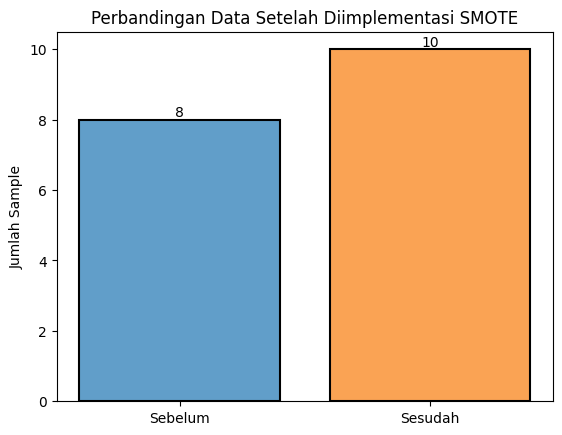

In [71]:
import matplotlib.pyplot as plt

x = ['Sebelum', 'Sesudah']
y = [len(stack_majority) + len(stack_minority), len(final_stack)]


plt.bar(x, y, color=[(0.38, 0.62, 0.79), (0.98, 0.64, 0.33)], edgecolor='black', linewidth=1.5)

for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='bottom')

plt.ylabel('Jumlah Sample')
plt.title('Perbandingan Data Setelah Diimplementasi SMOTE')

plt.show()

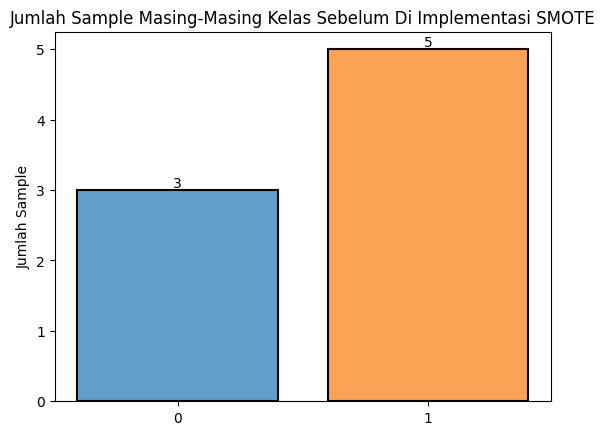

In [72]:
x = ['0', '1']
y = [df_bab3['Sarcasm'].value_counts()[0], df_bab3['Sarcasm'].value_counts()[1]]


plt.bar(x, y, color=[(0.38, 0.62, 0.79), (0.98, 0.64, 0.33)], edgecolor='black', linewidth=1.5)

for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='bottom')

plt.ylabel('Jumlah Sample')
plt.title('Jumlah Sample Masing-Masing Kelas Sebelum Di Implementasi SMOTE')

plt.show()

In [77]:
# Menghitung Jumlah Akhir Sample pada Class 0 dan 1
unique, counts = np.unique(final_stack_label, return_counts=True)

for label, count in zip(unique, counts):
    print(f'{label}: {count}')

0.0: 5
1.0: 5


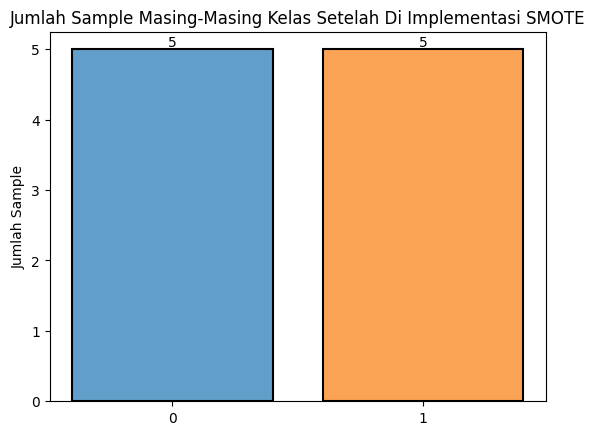

In [78]:
x = ['0', '1']
y = [counts[0], counts[1]]


plt.bar(x, y, color=[(0.38, 0.62, 0.79), (0.98, 0.64, 0.33)], edgecolor='black', linewidth=1.5)

for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='bottom')

plt.ylabel('Jumlah Sample')
plt.title('Jumlah Sample Masing-Masing Kelas Setelah Di Implementasi SMOTE')

plt.show()

<h2>Bi-LSTM</h2>

In [ ]:
x_train = final_stack
x_train = np.array(x_train)
label = final_stack_label.astype('int')
y_train = label

# Inisialisasi model Bi-LSTM
input_size = x_train.shape[1]
hidden_size = 8
output_size = 2
bilstm = BiLSTM(input_size, hidden_size, output_size)

In [ ]:
x_train

In [ ]:
# Train ML Model
epochs = 100
learning_rate = 0.01
bilstm.train(x_train, y_train, epochs, learning_rate)

In [ ]:
y_train

In [ ]:
x_train[9]

In [ ]:
# Predict ML Model
print(f'Predict Data 1 : {bilstm.predict(np.array([x_train[0]]))}\n')
print(f'Predict Data 2 : {bilstm.predict(np.array([x_train[1]]))}\n')
print(f'Predict Data 3 : {bilstm.predict(np.array([x_train[2]]))}\n')
print(f'Predict Data 4 : {bilstm.predict(np.array([x_train[3]]))}\n')
print(f'Predict Data 5 : {bilstm.predict(np.array([x_train[4]]))}\n')
print(f'Predict Data 6 : {bilstm.predict(np.array([x_train[5]]))}\n')
print(f'Predict Data 7 : {bilstm.predict(np.array([x_train[6]]))}\n')
print(f'Predict Data 8 : {bilstm.predict(np.array([x_train[7]]))}\n')
print(f'Predict Data 9 : {bilstm.predict(np.array([x_train[8]]))}\n')
print(f'Predict Data 10 : {bilstm.predict(np.array([x_train[9]]))}\n')